Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

Осуществить корректную загрузку данных осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую;
- проанализировать пропуски и решить, что с ними делать;
- проанализировать выбросы;
- создать/ удалить переменные;
- закодировать категориальные переменные;
- нормализовать числовые переменные (при необходимости);
- построить модель и оценить ее качество при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели.

Высокая цель. Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы.

Ожидаемый результат:
AUC на обучающей выборке: 0.865
AUC на контрольной выборке: 0.854
Рекомендую построить Confusion matrix что бы понять как ваша модель ошибаеться.

In [1]:
!!pip install xgboost

['Collecting xgboost',
 '  Downloading xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)',
 '     ---------------------------------------- 70.9/70.9 MB 3.8 MB/s eta 0:00:00',
 'Requirement already satisfied: scipy in c:\\users\\koshk\\anaconda3\\lib\\site-packages (from xgboost) (1.9.1)',
 'Requirement already satisfied: numpy in c:\\users\\koshk\\anaconda3\\lib\\site-packages (from xgboost) (1.23.5)',
 'Installing collected packages: xgboost',
 'Successfully installed xgboost-1.7.6']

In [8]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

import xgboost as xgb
from numpy import nan

In [23]:
# импортируем файл с данными из .csv. Выводим 10 строк из файла
DataFrame = pd.read_csv("MFOcredit.csv", encoding='cp1251', sep=';')
DataFrame.head(5)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [24]:
# преобразуем значения в цисловые с помощью метода map в столбце delinq60plus
#DataFrame['delinq60plus'] = DataFrame['delinq60plus'].map({'Да': 1, 'Нет': 0})
DataFrame['gender'] = DataFrame['gender'].apply(lambda x: 1 if x == 'Мужской' else 0 if x == 'Женский' else nan)
DataFrame['delinq60plus'] = DataFrame['delinq60plus'].apply(lambda x: 1 if x == 'Да' else 0 if x == 'Нет' else nan)
DataFrame['regclient'] = DataFrame['regclient'].apply(lambda x: 1 if x == 'Да' else 0 if x == 'Нет' else nan)
DataFrame['credits'] = DataFrame['credits'].apply(lambda x: 1 if x == 'Да' else 0 if x == 'Нет' else nan)
DataFrame['children'] = DataFrame['children'].apply(lambda x: 1 if x == 'Да' else 0 if x == 'Нет' else nan)

In [25]:
DataFrame.head(5)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,1,44,Нет,Собственное,Гражданский брак/женат/замужем,0,Официальное,Новосибирская область,0.0,1.0,0
1,2,03-Jan-2013,17-Jan-2013,1,21,Пропуск поля,Живут с родителями,Холост,0,Официальное,Кемеровская область юг,1.0,0.0,0
2,3,03-Jan-2013,17-Jan-2013,1,25,Пропуск поля,Собственное,Холост,1,Официальное,Кемеровская область север,NaN,0.0,0
3,4,03-Jan-2013,17-Jan-2013,0,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,1,Официальное,Кемеровская область север,0.0,0.0,0
4,5,03-Jan-2013,17-Jan-2013,1,22,Нет,Арендуемое,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область север,1.0,1.0,0


In [26]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            35212 non-null  int64  
 1   date_start    35212 non-null  object 
 2   date_end      35212 non-null  object 
 3   gender        35212 non-null  int64  
 4   age           35212 non-null  int64  
 5   auto          35212 non-null  object 
 6   housing       35212 non-null  object 
 7   marstatus     35212 non-null  object 
 8   regclient     35212 non-null  int64  
 9   jobtype       35212 non-null  object 
 10  region        35212 non-null  object 
 11  credits       34266 non-null  float64
 12  children      34467 non-null  float64
 13  delinq60plus  35212 non-null  int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 3.8+ MB


In [27]:
# формируем признак term
DataFrame['date_start']= pd.to_datetime(DataFrame['date_start'])
DataFrame['date_end']= pd.to_datetime(DataFrame['date_end'])
#DataFrame["term"] = (DataFrame['date_end']-DataFrame['date_start']).dt.days

In [28]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            35212 non-null  int64         
 1   date_start    35212 non-null  datetime64[ns]
 2   date_end      35212 non-null  datetime64[ns]
 3   gender        35212 non-null  int64         
 4   age           35212 non-null  int64         
 5   auto          35212 non-null  object        
 6   housing       35212 non-null  object        
 7   marstatus     35212 non-null  object        
 8   regclient     35212 non-null  int64         
 9   jobtype       35212 non-null  object        
 10  region        35212 non-null  object        
 11  credits       34266 non-null  float64       
 12  children      34467 non-null  float64       
 13  delinq60plus  35212 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(5)
memory usage: 3.8+ MB


In [29]:
con = sqlite3.connect('db') #соединяемся с виртуальной базой db 

In [30]:
DataFrame.to_sql('MFOcredit',con,index=False,if_exists='replace')

35212

In [31]:
def select(sql):
  return pd.read_sql(sql,con)

In [33]:
sql = '''SELECT * FROM MFOcredit AS t'''

In [34]:
select(sql)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,2013-01-03 00:00:00,2013-01-12 00:00:00,1,44,Нет,Собственное,Гражданский брак/женат/замужем,0,Официальное,Новосибирская область,0.0,1.0,0
1,2,2013-01-03 00:00:00,2013-01-17 00:00:00,1,21,Пропуск поля,Живут с родителями,Холост,0,Официальное,Кемеровская область юг,1.0,0.0,0
2,3,2013-01-03 00:00:00,2013-01-17 00:00:00,1,25,Пропуск поля,Собственное,Холост,1,Официальное,Кемеровская область север,NaN,0.0,0
3,4,2013-01-03 00:00:00,2013-01-17 00:00:00,0,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,1,Официальное,Кемеровская область север,0.0,0.0,0
4,5,2013-01-03 00:00:00,2013-01-17 00:00:00,1,22,Нет,Арендуемое,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область север,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35207,35208,2014-01-03 00:00:00,2014-01-17 00:00:00,1,30,Да,Долевая собственность,Гражданский брак/женат/замужем,1,Официальное,Алтайский край,1.0,1.0,0
35208,35209,2014-01-03 00:00:00,2014-01-17 00:00:00,0,57,Нет,Собственное,Разведен,1,Пропуск поля,Алтайский край,1.0,0.0,0
35209,35210,2014-01-03 00:00:00,2014-01-17 00:00:00,0,38,Пропуск поля,Пропуск поля,Пропуск поля,1,Пропуск поля,Новосибирская область,0.0,1.0,0
35210,35211,2014-01-03 00:00:00,2014-01-17 00:00:00,0,19,Пропуск поля,Пропуск поля,Пропуск поля,1,Пропуск поля,Кемеровская область юг,0.0,0.0,0


In [35]:
sql = '''SELECT t.age * 3 AS age_mult3,
       t.housing, t.gender AS non_gender
FROM MFOcredit AS t
'''

In [36]:
select(sql)

,age_mult3,housing,non_gender
0,132,Собственное,1
1,63,Живут с родителями,1
2,75,Собственное,1
3,141,Собственное,0
4,66,Арендуемое,1
...,...,...,...
35207,90,Долевая собственность,1
35208,171,Собственное,0
35209,114,Пропуск поля,0
35210,57,Пропуск поля,0


In [37]:
sql = '''select * from MFOcredit t limit 5'''

In [38]:
select(sql)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,2013-01-03 00:00:00,2013-01-12 00:00:00,1,44,Нет,Собственное,Гражданский брак/женат/замужем,0,Официальное,Новосибирская область,0.0,1.0,0
1,2,2013-01-03 00:00:00,2013-01-17 00:00:00,1,21,Пропуск поля,Живут с родителями,Холост,0,Официальное,Кемеровская область юг,1.0,0.0,0
2,3,2013-01-03 00:00:00,2013-01-17 00:00:00,1,25,Пропуск поля,Собственное,Холост,1,Официальное,Кемеровская область север,NaN,0.0,0
3,4,2013-01-03 00:00:00,2013-01-17 00:00:00,0,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,1,Официальное,Кемеровская область север,0.0,0.0,0
4,5,2013-01-03 00:00:00,2013-01-17 00:00:00,1,22,Нет,Арендуемое,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область север,1.0,1.0,0


In [42]:
#Посчитать сколько мужчин в возрасте между 28 и 40 живут в Новосибирской области и не имеют кредит
sql = '''select count(1) from MFOcredit t 
where t.age between 28 and 40 AND t.gender = '1' AND t.region = 'Новосибирская область' AND t.credits = '1'
'''

In [43]:
select(sql)

,count(1)
0,294


In [44]:
#Посчитать в Новг.обл. с кредитами между датами '2013-01-01' and '2013-06-31'
sql = '''select count(1) from MFOcredit t 
where t.region = 'Новосибирская область' AND t.date_start between '2013-01-01' and '2013-06-31' AND t.credits = '0'
'''

In [45]:
select(sql)

,count(1)
0,916


In [46]:
DataFrame.to_sql('region',con,index=False,if_exists='replace')

35212

In [47]:
#выбираем возраст от 48 до 50 без детей, в регионе есть слова "юг" "север"
sql = '''select * from region t
where (t.region like '%юг%'
or t.region like '%север%') AND t.children = '1' AND t.age between 50 and 52
'''

In [48]:
select(sql)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1138,2013-01-30 00:00:00,2013-02-08 00:00:00,1,52,Да,Собственное,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область юг,0.0,1.0,0
1,1551,2013-02-07 00:00:00,2013-02-16 00:00:00,0,51,Пропуск поля,Собственное,Гражданский брак/женат/замужем,0,Пропуск поля,Кемеровская область север,1.0,1.0,0
2,2318,2013-02-21 00:00:00,2013-03-07 00:00:00,0,50,Нет,Собственное,Холост,0,Пропуск поля,Кемеровская область север,1.0,1.0,1
3,2571,2013-02-26 00:00:00,2013-03-12 00:00:00,0,50,Пропуск поля,Собственное,Вдова/вдовец,1,Официальное,Кемеровская область север,1.0,1.0,1
4,2664,2013-02-28 00:00:00,2013-03-14 00:00:00,0,50,Нет,Долевая собственность,Разведен,1,Пропуск поля,Кемеровская область юг,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,34525,2013-12-30 00:00:00,2014-01-13 00:00:00,1,52,Пропуск поля,Собственное,Гражданский брак/женат/замужем,1,Пропуск поля,Кемеровская область юг,1.0,1.0,0
101,34732,2013-12-31 00:00:00,2014-01-04 00:00:00,0,52,Пропуск поля,Пропуск поля,Пропуск поля,1,Пропуск поля,Кемеровская область север,1.0,1.0,0
102,34829,2013-12-31 00:00:00,2014-01-14 00:00:00,0,50,Пропуск поля,Собственное,Разведен,1,Пропуск поля,Кемеровская область север,0.0,1.0,0
103,34857,2013-12-31 00:00:00,2014-01-14 00:00:00,1,52,Да,Собственное,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область юг,0.0,1.0,0


In [49]:
sql = '''select count(t.housing), count(0) from MFOcredit t'''

In [50]:
select(sql)

,count(t.housing),count(0)
0,35212,35212


In [ ]:
#Построить сводную таблицу (сгруппировать по) region(региону) по полу и посчитать средний возраст (avg)

In [51]:
sql = '''select t.region, 

count(case when t.gender = '0' then 1 else null end) as female,
count(case when t.gender = '1' then 1 else null end) as male,
avg(t.age) as avg_age,
count() as cnt 

from MFOcredit t
group  by t.region'''

In [52]:
select(sql)

,region,female,male,avg_age,cnt
0,Алтайский край,2814,2358,37.288283,5172
1,Кемеровская область север,6659,5788,37.986663,12447
2,Кемеровская область юг,5219,5803,36.226093,11022
3,Красноярский край,1307,937,38.476381,2244
4,Новосибирская область,2276,2051,37.004622,4327


In [53]:
#разбиваем данные на тестовые и обучающие
X = DataFrame.drop(["gender"], axis=1)
Y = DataFrame["gender"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [54]:
# разбиение данных на категориальные и числовые
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', "bool"]).columns

# формирование Pipeline предобработки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [55]:
# используем ColumnTransformer для формирования препроцессинга предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [56]:
#SGDClassifier
# формирование Pipeline
SGD_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier ())])

# формирование сетки гиперпараметров
param_grid_SGD = {'classifier__penalty': ['l1', 'l2'],
                  'classifier__loss' : ['hinge', 'log', 'modified_huber'],
                  'classifier__alpha' : [0.0001, 0.001]}
SGD_clf_grid = GridSearchCV(SGD_clf, param_grid_SGD, cv = 5, verbose = 0, n_jobs = -1)

# обучение и предсказание
SGD_clf_grid.fit(X_train, Y_train)
pred_SGD_clf = SGD_clf_grid.predict(X_test)


In [57]:
classification_report(Y_test, pred_SGD_clf)

'              precision    recall  f1-score   support\n\n           0       0.65      0.74      0.69      4609\n           1       0.67      0.57      0.61      4194\n\n    accuracy                           0.66      8803\n   macro avg       0.66      0.65      0.65      8803\nweighted avg       0.66      0.66      0.66      8803\n'

Text(0, 0.5, 'Точность')

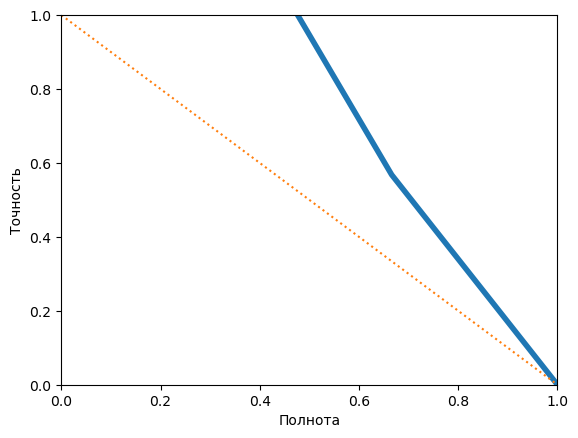

In [58]:
pre, rec, tr = precision_recall_curve(Y_test, pred_SGD_clf)
plt.plot(pre, rec, linewidth = 4)
plt.plot([0,1], [1,0], ':')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')